In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter("ignore")

Get the data

In [2]:
data_link = "wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
!wget -c $data_link

--2023-10-08 23:24:33--  http://wget/
Resolving wget (wget)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘wget’
--2023-10-08 23:24:33--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [3]:
data = pd.read_csv("data.csv")

**Data Preparation**

In [4]:
# Keeping only the following columns
cols = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP"
]
df = data[cols]

# Lowercase the column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(" ", "_")
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Fill the missing values with 0
df["engine_hp"].fillna(0, inplace=True)
df["engine_cylinders"].fillna(0, inplace=True)

# Make the price binary (1 if above the average, 0 otherwise) - 
# this will be our target variable `above_average`
df["above_average"] = (df["msrp"] > df["msrp"].mean()).astype(int)
df.drop("msrp", axis=1, inplace=True)

Spliting the data into 3 parts: train/validation/test with 60%/20%/20% distribution with `random_state = 1`

In [5]:
rs = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["above_average"].values
y_val = df_val["above_average"].values
y_test = df_test["above_average"].values

df_train.drop("above_average", axis=1, inplace=True)
df_val.drop("above_average", axis=1, inplace=True)
df_test.drop("above_average", axis=1, inplace=True)

print(f"df_train: {len(df_train)} | {len(df_train) / len(df)*100:.0f}%")
print(f"df_val: {len(df_val)} | {len(df_val) / len(df)*100:.0f}%")
print(f"df_test: {len(df_test)} | {len(df_test) / len(df)*100:.0f}%")

df_train: 7148 | 60%
df_val: 2383 | 20%
df_test: 2383 | 20%


### Question 1: ROC AUC feature importance

In [6]:
numerical = ["year", "engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]
categorical = ["make", "model", "transmission_type", "vehicle_style"]
print("numerical: ", numerical)
print("categorical: ", categorical)

numerical:  ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical:  ['make', 'model', 'transmission_type', 'vehicle_style']


In [7]:
# computint the AUC score
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f"AUC({c}): {auc:.6f}")


AUC(year): 0.687551
AUC(engine_hp): 0.917103
AUC(engine_cylinders): 0.766116
AUC(highway_mpg): 0.633059
AUC(city_mpg): 0.673424


**Solution:** `engine_hp`

### Question 2: Training the model

In [8]:
def train(df_train, y_train, C=1.0):
    train_dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [9]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [10]:
print(f"AUC: {roc_auc_score(y_val, y_pred):.6f}")

AUC: 0.976350


**Solution:** `0.979`

### Question 3: Precision and Recall

Compute `precision` and `recall` for our model

- $\text{Precision} = \frac{tp}{tp + fp}$
- $\text{Recall} = \frac{tp}{tp + fn}$

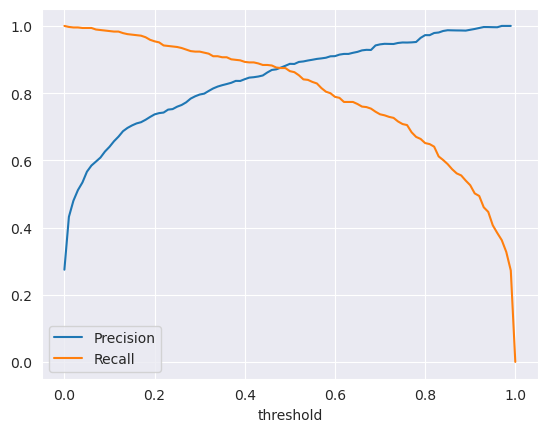

In [11]:
# Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.linspace(0.0, 1.0, 101)

def confusion_matrix_data(y_val, y_pred, thresholds):
    scores = []

    for t in thresholds:
        # For each threshold, compute precision and recall
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)

        tp = (pred_positive & actual_positive).sum()
        tn = (pred_negative & actual_negative).sum()

        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()

        scores.append((t, tp, fp, tn, fn))

    columns = ["threshold", "tp", "fp", "tn", "fn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores


df_scores = confusion_matrix_data(y_val, y_pred, thresholds)

df_scores["P"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fp"])
df_scores["R"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])

# Plot them
plt.plot(df_scores["threshold"], df_scores["P"], label="Precision")
plt.plot(df_scores["threshold"], df_scores["R"], label="Recall")
plt.xlabel("threshold")
plt.legend()
plt.show()


**Solution:** $0.48$

### Question 4: F1 score

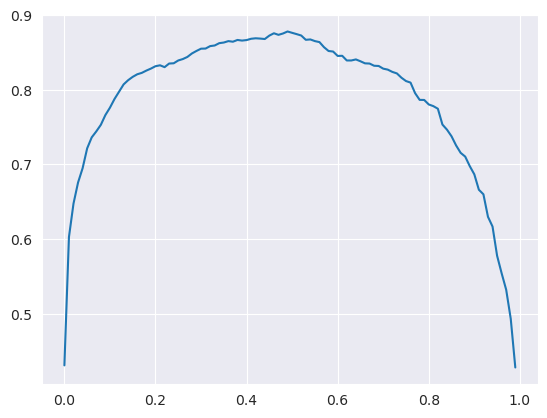

Optimal F1: 0.8780, t: 0.49


In [12]:
df_scores["F1"] = 2 * (df_scores["P"] * df_scores["R"]) / (df_scores["P"] + df_scores["R"])
plt.plot(df_scores["threshold"], df_scores["F1"])
plt.show()

max_idx = df_scores['F1'].argmax()
print(f"Optimal F1: {df_scores['F1'].iloc[max_idx]:.4f}, t: {df_scores['threshold'].iloc[max_idx]}")

**Solution:** $0.52$
- The nearest value to the result + also around the area where Precision and Recall intersect#

### Question 5: 5-Fold CV

In [13]:
from tqdm import tqdm

In [14]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train["above_average"].values
    y_val = df_val["above_average"].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"AUC: {np.mean(scores):.3f} +- {np.std(scores):.3f}")


AUC: 0.981 +- 0.004


**Solution:** $0.003$

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [15]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=rs)
scores = []

for C in [0.01, 0.1, 0.5, 10.0]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train["above_average"].values
        y_val = df_val["above_average"].values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"C: {C:4} | AUC: {np.mean(scores):.3f} +- {np.std(scores):.3f}")


C: 0.01 | AUC: 0.952 +- 0.002
C:  0.1 | AUC: 0.972 +- 0.002
C:  0.5 | AUC: 0.977 +- 0.001
C: 10.0 | AUC: 0.983 +- 0.002


**Solution:** $C=10$